In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
import sys, time

2024-03-26 16:11:26.813685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 16:11:26.813778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 16:11:26.973075: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 16:11:27.736248: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 16:11:33.119010: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from timeVAE.vae_dense_model import VariationalAutoencoderDense as VAE_Dense
from timeVAE.vae_conv_model import VariationalAutoencoderConv as VAE_Conv
from timeVAE.vae_conv_I_model import VariationalAutoencoderConvInterpretable as TimeVAE
from timeVAE import utils
from sklearn.preprocessing import MinMaxScaler

In [3]:
MODEL = 0 # 0 = th v air, 1 = el v sky

In [4]:
index = [0,3] if MODEL==0 else [1,2]
model_name = 'th_v_air' if MODEL==0 else 'el_v_sky'

base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)
base_data_train, base_data_test = base_data_train[:,:,index], base_data_test[:,:,index] # 0,3 = th vs air; 1,2 = el vs sky
print(base_data_train.shape, base_data_test.shape)

(108, 730, 2) (12, 730, 2)


In [5]:
#print(base_data_train, base_data_test)

In [6]:
import tensorflow as tf

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

<h3> Scale data </h3>

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Important to store each of the scalers we use for inverse transforming later
scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I', 'month']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]
#indicator_var, indicator_var_test = base_data_train[:,:,2], base_data_test[:,:,2]

temp_var = scalers['G.air.T'].fit_transform(temp_var)
energy_var = scalers['G.E_th_I'].fit_transform(energy_var)
#indicator_var = scalers['month'].fit_transform(indicator_var)

temp_var_test = scalers['G.air.T'].fit_transform(temp_var_test)
energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var_test)
#indicator_var_test = scalers['month'].fit_transform(indicator_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 2) (12, 730, 2)


<h3> Build VAE </h3>

In [8]:
LATENT_DIM    = 3
LEARNING_RATE = 0.001
EPOCHS        = 1000
BATCH_SIZE    = 4


In [26]:
seq_len = base_data_train.shape[1]
feat_dim = base_data_train.shape[2]

hidden_layer_sizes = [64,128,64]

model = TimeVAE(seq_len=seq_len, 
                feat_dim=feat_dim, 
                latent_dim=LATENT_DIM, 
                hidden_layer_sizes=hidden_layer_sizes,
                use_scaler=False)

In [27]:
model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 730, 2)]             0         []                            
                                                                                                  
 enc_conv_0 (Conv1D)         (None, 365, 64)              448       ['encoder_input[0][0]']       
                                                                                                  
 enc_conv_1 (Conv1D)         (None, 183, 128)             24704     ['enc_conv_0[0][0]']          
                                                                                                  
 enc_conv_2 (Conv1D)         (None, 92, 64)               24640     ['enc_conv_1[0][0]']          
                                                                                            

In [28]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='loss')

<h3> Run VAE </h3>

In [29]:
early_stop = EarlyStopping(monitor='reconstruction_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='reconstruction_loss', factor=0.5, patience=5, verbose=1)

model.fit(scaled_data_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        shuffle = True,
        callbacks = [early_stop, reduce_lr],
        verbose = 1)

Epoch 1/1000


2024-03-26 14:28:49.899082: I external/local_xla/xla/service/service.cc:168] XLA service 0x1b7eaf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-03-26 14:28:49.899115: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-03-26 14:28:49.918250: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 7/27 [======>.......................] - ETA: 0s - loss: 13471.0907 - reconstruction_loss: 3996.9236 - kl_loss: 7.4491

I0000 00:00:1711463330.157064  233067 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-26 14:28:50.160174: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-26 14:28:50.163336: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-26 14:28:50.163554: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-26 14:28:50.163723: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-26 14:28:50.260186: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-26 14:28:50.260461: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplement

18/27 [===================>..........] - ETA: 0s - loss: 10850.9551 - reconstruction_loss: 2552.0203 - kl_loss: 59.2276

2024-03-26 14:28:50.366188: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


27/27 [==============================] - 3s 17ms/step - loss: 9417.1963 - reconstruction_loss: 2101.5139 - kl_loss: 113.1870 - lr: 0.0010
Epoch 2/1000
27/27 [==============================] - 0s 16ms/step - loss: 3872.4354 - reconstruction_loss: 1172.4628 - kl_loss: 223.8797 - lr: 0.0010
Epoch 3/1000
27/27 [==============================] - 0s 16ms/step - loss: 3422.4973 - reconstruction_loss: 1095.8846 - kl_loss: 152.4340 - lr: 0.0010
Epoch 4/1000
27/27 [==============================] - 0s 15ms/step - loss: 3664.7103 - reconstruction_loss: 1047.2085 - kl_loss: 114.7614 - lr: 0.0010
Epoch 5/1000
27/27 [==============================] - 0s 16ms/step - loss: 2985.7998 - reconstruction_loss: 1013.1166 - kl_loss: 94.2568 - lr: 0.0010
Epoch 6/1000
22/27 [=======================>......] - ETA: 0s - loss: 3296.5011 - reconstruction_loss: 1014.0369 - kl_loss: 84.5150

2024-03-26 14:28:52.635666: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


27/27 [==============================] - 0s 17ms/step - loss: 3253.4608 - reconstruction_loss: 1000.3420 - kl_loss: 84.5297 - lr: 0.0010
Epoch 7/1000
27/27 [==============================] - 0s 16ms/step - loss: 3236.7049 - reconstruction_loss: 972.5823 - kl_loss: 74.6641 - lr: 0.0010
Epoch 8/1000
27/27 [==============================] - 0s 18ms/step - loss: 2882.7713 - reconstruction_loss: 958.4902 - kl_loss: 70.5442 - lr: 0.0010
Epoch 9/1000
27/27 [==============================] - 0s 17ms/step - loss: 2985.5028 - reconstruction_loss: 959.0327 - kl_loss: 65.5622 - lr: 0.0010
Epoch 10/1000
27/27 [==============================] - 0s 17ms/step - loss: 2991.4852 - reconstruction_loss: 946.6687 - kl_loss: 60.9600 - lr: 0.0010
Epoch 11/1000
27/27 [==============================] - 0s 17ms/step - loss: 2944.6072 - reconstruction_loss: 938.5452 - kl_loss: 58.3036 - lr: 0.0010
Epoch 12/1000
27/27 [==============================] - 0s 16ms/step - loss: 2864.9959 - reconstruction_loss: 931.007

2024-03-26 14:29:06.402888: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


27/27 [==============================] - 0s 16ms/step - loss: 1588.9830 - reconstruction_loss: 525.8102 - kl_loss: 50.5842 - lr: 0.0010
Epoch 38/1000
27/27 [==============================] - 0s 18ms/step - loss: 1663.6309 - reconstruction_loss: 524.2079 - kl_loss: 52.6084 - lr: 0.0010
Epoch 39/1000
27/27 [==============================] - 0s 17ms/step - loss: 1547.3129 - reconstruction_loss: 517.0974 - kl_loss: 52.2543 - lr: 0.0010
Epoch 40/1000
27/27 [==============================] - 0s 16ms/step - loss: 1593.4320 - reconstruction_loss: 517.8911 - kl_loss: 54.7117 - lr: 0.0010
Epoch 41/1000
27/27 [==============================] - 0s 16ms/step - loss: 1573.5671 - reconstruction_loss: 511.7498 - kl_loss: 54.2120 - lr: 0.0010
Epoch 42/1000
27/27 [==============================] - 0s 17ms/step - loss: 1516.5663 - reconstruction_loss: 502.7527 - kl_loss: 52.2887 - lr: 0.0010
Epoch 43/1000
27/27 [==============================] - 0s 17ms/step - loss: 1571.3143 - reconstruction_loss: 496.3

27/27 [==============================] - 0s 18ms/step - loss: 1083.7009 - reconstruction_loss: 354.0432 - kl_loss: 55.9624 - lr: 2.5000e-04
Epoch 89/1000
27/27 [==============================] - 0s 16ms/step - loss: 1123.5930 - reconstruction_loss: 350.9146 - kl_loss: 56.1915 - lr: 2.5000e-04
Epoch 90/1000
27/27 [==============================] - 0s 16ms/step - loss: 1115.1478 - reconstruction_loss: 349.6404 - kl_loss: 56.3766 - lr: 2.5000e-04
Epoch 91/1000
27/27 [==============================] - 0s 16ms/step - loss: 1131.2179 - reconstruction_loss: 351.0199 - kl_loss: 56.3208 - lr: 2.5000e-04
Epoch 92/1000
27/27 [==============================] - 0s 16ms/step - loss: 1113.9051 - reconstruction_loss: 346.9002 - kl_loss: 55.4032 - lr: 2.5000e-04
Epoch 93/1000
27/27 [==============================] - 0s 16ms/step - loss: 1089.6740 - reconstruction_loss: 344.9383 - kl_loss: 55.8082 - lr: 2.5000e-04
Epoch 94/1000
27/27 [==============================] - 0s 16ms/step - loss: 1038.7076 - re

Epoch 140/1000
27/27 [==============================] - 0s 16ms/step - loss: 777.7866 - reconstruction_loss: 250.6461 - kl_loss: 60.4632 - lr: 1.2500e-04
Epoch 141/1000
27/27 [==============================] - 0s 16ms/step - loss: 783.9406 - reconstruction_loss: 249.8046 - kl_loss: 59.7003 - lr: 1.2500e-04
Epoch 142/1000
27/27 [==============================] - 0s 16ms/step - loss: 809.9323 - reconstruction_loss: 246.0635 - kl_loss: 59.6072 - lr: 1.2500e-04
Epoch 143/1000
27/27 [==============================] - 0s 16ms/step - loss: 784.9037 - reconstruction_loss: 245.4486 - kl_loss: 60.1358 - lr: 1.2500e-04
Epoch 144/1000
27/27 [==============================] - 0s 17ms/step - loss: 749.9196 - reconstruction_loss: 244.3725 - kl_loss: 59.9689 - lr: 1.2500e-04
Epoch 145/1000
27/27 [==============================] - 0s 17ms/step - loss: 821.7595 - reconstruction_loss: 244.2260 - kl_loss: 60.2053 - lr: 1.2500e-04
Epoch 146/1000
27/27 [==============================] - 0s 16ms/step - loss:

Epoch 192/1000
27/27 [==============================] - 0s 17ms/step - loss: 675.6372 - reconstruction_loss: 199.2574 - kl_loss: 62.3758 - lr: 6.2500e-05
Epoch 193/1000
27/27 [==============================] - 0s 17ms/step - loss: 719.1572 - reconstruction_loss: 199.1908 - kl_loss: 62.2324 - lr: 6.2500e-05
Epoch 194/1000
27/27 [==============================] - 0s 18ms/step - loss: 638.6912 - reconstruction_loss: 198.1387 - kl_loss: 62.4416 - lr: 6.2500e-05
Epoch 195/1000
27/27 [==============================] - 0s 18ms/step - loss: 675.5738 - reconstruction_loss: 197.7001 - kl_loss: 62.5963 - lr: 6.2500e-05
Epoch 196/1000
27/27 [==============================] - 0s 17ms/step - loss: 649.1976 - reconstruction_loss: 197.1488 - kl_loss: 62.4697 - lr: 6.2500e-05
Epoch 197/1000
27/27 [==============================] - 0s 17ms/step - loss: 631.9265 - reconstruction_loss: 196.2794 - kl_loss: 62.6145 - lr: 6.2500e-05
Epoch 198/1000
27/27 [==============================] - 0s 17ms/step - loss:

27/27 [==============================] - 0s 16ms/step - loss: 539.4897 - reconstruction_loss: 155.5379 - kl_loss: 63.0955 - lr: 3.1250e-05
Epoch 298/1000
27/27 [==============================] - 0s 16ms/step - loss: 577.2340 - reconstruction_loss: 155.3050 - kl_loss: 63.2526 - lr: 3.1250e-05
Epoch 299/1000
27/27 [==============================] - 0s 17ms/step - loss: 573.7088 - reconstruction_loss: 155.2674 - kl_loss: 63.4468 - lr: 3.1250e-05
Epoch 300/1000
27/27 [==============================] - 0s 17ms/step - loss: 527.4730 - reconstruction_loss: 154.5428 - kl_loss: 63.5236 - lr: 3.1250e-05
Epoch 301/1000
27/27 [==============================] - 0s 17ms/step - loss: 577.3350 - reconstruction_loss: 154.5285 - kl_loss: 63.5199 - lr: 3.1250e-05
Epoch 302/1000
27/27 [==============================] - 0s 18ms/step - loss: 553.5602 - reconstruction_loss: 154.1583 - kl_loss: 63.4482 - lr: 3.1250e-05
Epoch 303/1000
27/27 [==============================] - 0s 17ms/step - loss: 490.5873 - rec

27/27 [==============================] - 0s 17ms/step - loss: 557.6321 - reconstruction_loss: 145.7464 - kl_loss: 63.7618 - lr: 1.5625e-05
Epoch 350/1000
27/27 [==============================] - 0s 16ms/step - loss: 452.5404 - reconstruction_loss: 145.5459 - kl_loss: 63.6991 - lr: 1.5625e-05
Epoch 351/1000
27/27 [==============================] - 0s 17ms/step - loss: 464.4871 - reconstruction_loss: 145.7700 - kl_loss: 63.7235 - lr: 1.5625e-05
Epoch 352/1000
27/27 [==============================] - 0s 18ms/step - loss: 469.8861 - reconstruction_loss: 144.9451 - kl_loss: 63.6123 - lr: 1.5625e-05
Epoch 353/1000
27/27 [==============================] - 0s 16ms/step - loss: 457.7537 - reconstruction_loss: 145.9155 - kl_loss: 63.5897 - lr: 1.5625e-05
Epoch 354/1000
27/27 [==============================] - 0s 16ms/step - loss: 471.0673 - reconstruction_loss: 144.9589 - kl_loss: 63.5377 - lr: 1.5625e-05
Epoch 355/1000
27/27 [==============================] - 0s 16ms/step - loss: 499.2019 - rec

2024-03-26 14:31:33.252845: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


27/27 [==============================] - 0s 16ms/step - loss: 515.2900 - reconstruction_loss: 144.3722 - kl_loss: 63.8815 - lr: 7.8125e-06
Epoch 364/1000
27/27 [==============================] - 0s 18ms/step - loss: 528.0911 - reconstruction_loss: 143.7521 - kl_loss: 63.9099 - lr: 7.8125e-06
Epoch 365/1000
27/27 [==============================] - 0s 16ms/step - loss: 532.2851 - reconstruction_loss: 144.0557 - kl_loss: 63.7718 - lr: 7.8125e-06
Epoch 366/1000
27/27 [==============================] - 0s 16ms/step - loss: 491.0175 - reconstruction_loss: 143.7539 - kl_loss: 63.7499 - lr: 7.8125e-06
Epoch 367/1000
27/27 [==============================] - 0s 16ms/step - loss: 500.9994 - reconstruction_loss: 143.9079 - kl_loss: 63.6863 - lr: 7.8125e-06
Epoch 368/1000
27/27 [==============================] - 0s 16ms/step - loss: 508.3637 - reconstruction_loss: 143.8510 - kl_loss: 63.6468 - lr: 7.8125e-06
Epoch 369/1000
27/27 [==============================] - 0s 16ms/step - loss: 491.3149 - rec

[]

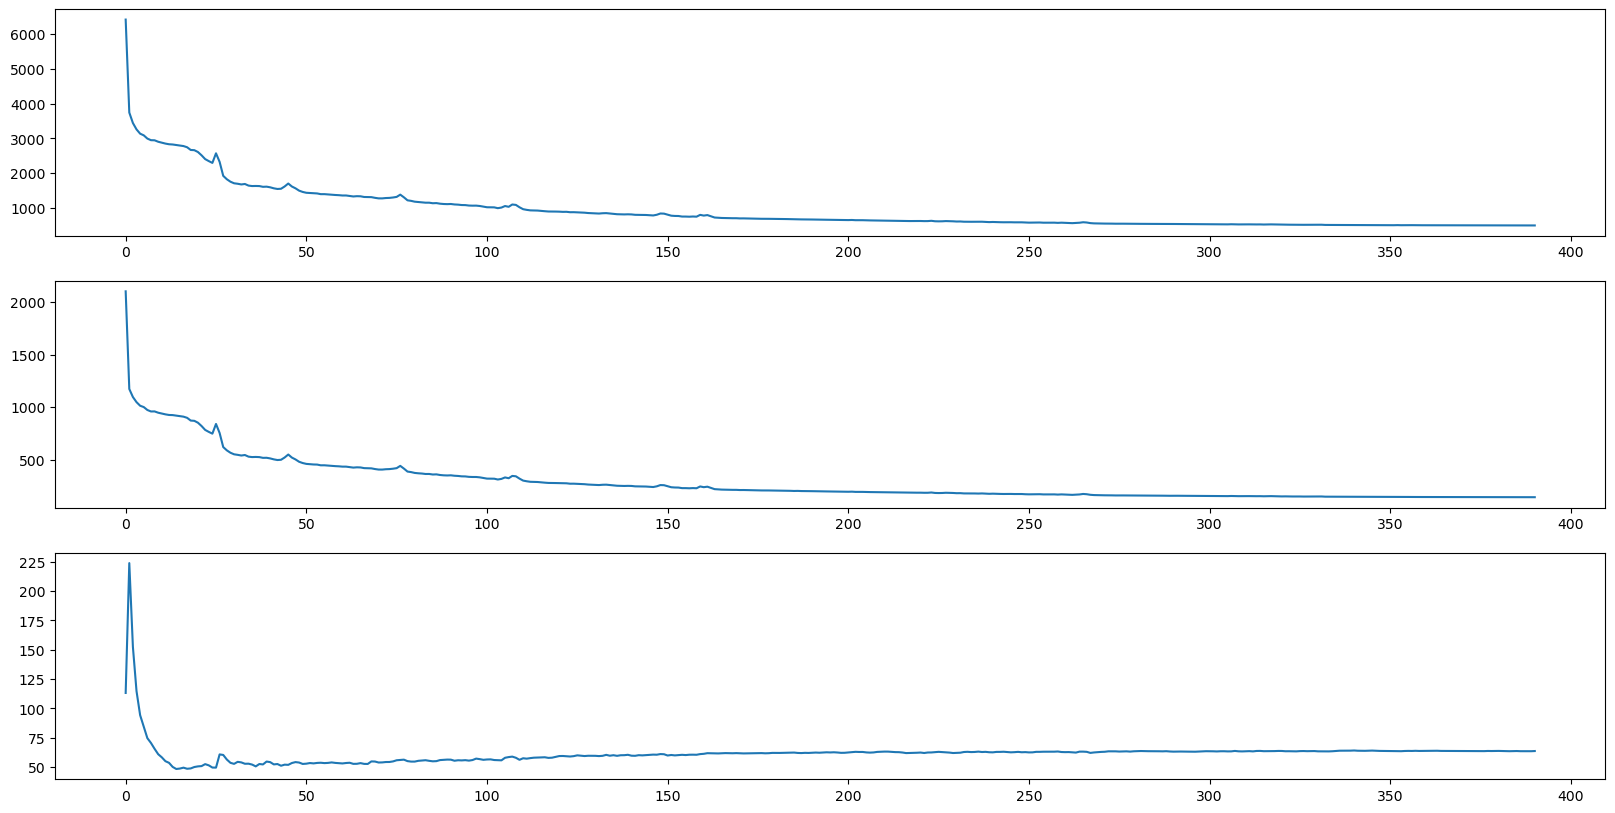

In [30]:
fig, ax = plt.subplots(3,1,figsize=(20,10))
ax[0].plot(model.history.history['loss'])
ax[1].plot(model.history.history['reconstruction_loss'])
ax[2].plot(model.history.history['kl_loss'])
plt.plot()

<h3> Generate synthetic samples </h3>

In [31]:
num_samples = 1000
generated_samples = model.get_prior_samples(num_samples=num_samples)
print(generated_samples.shape)

32/32 [==============================] - 0s 6ms/step
(1000, 730, 2)


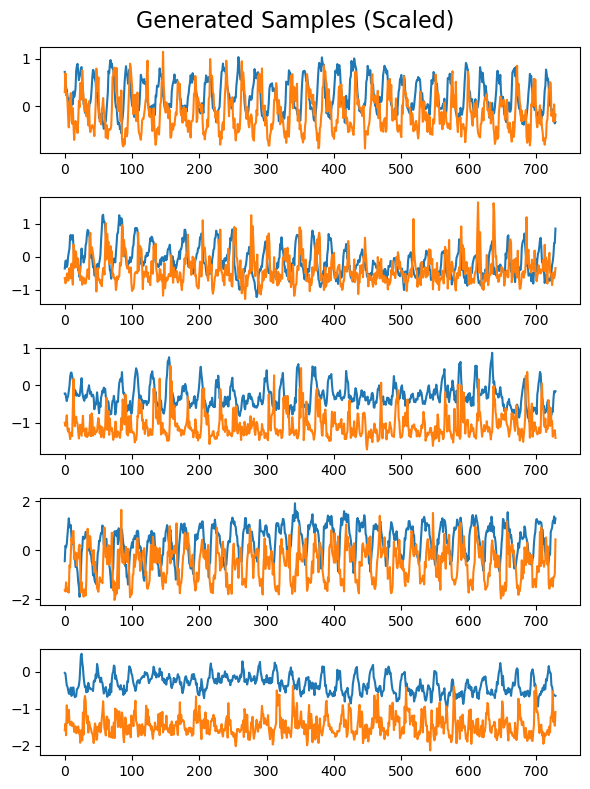

In [32]:
utils.plot_samples(generated_samples,n=5)

In [33]:
temp_var, energy_var = generated_samples[:,:,0], generated_samples[:,:,1]
temp_var, energy_var = scalers['G.air.T'].inverse_transform(temp_var), scalers['G.E_th_I'].inverse_transform(energy_var)

rescaled_samples = np.stack((temp_var, energy_var),axis=-1)

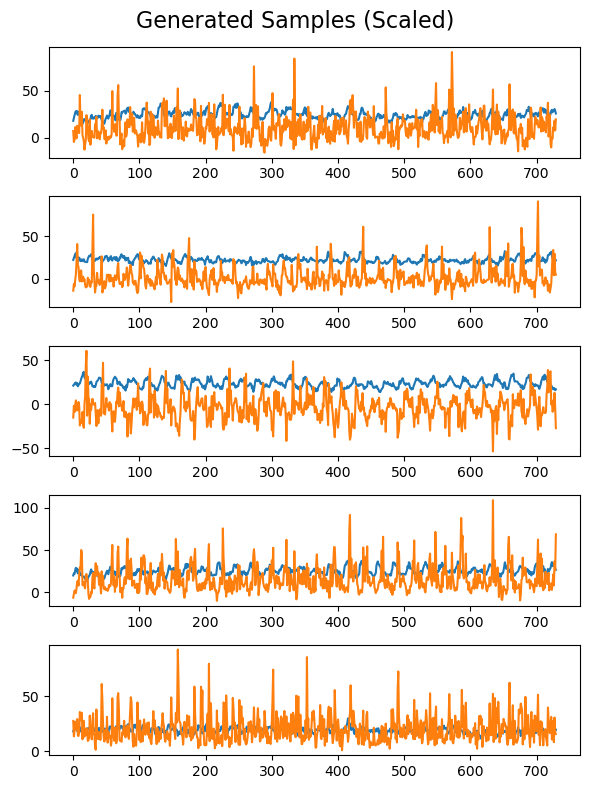

In [34]:
utils.plot_samples(rescaled_samples,n=5)

In [35]:
np.save(f'../../data/test_vae_data/{model_name}_generated_samples.npy', generated_samples)
np.save(f'../../data/test_vae_data/{model_name}_rescaled_samples.npy', rescaled_samples)

In [36]:
loss = pd.DataFrame(model.history.history)
loss.to_csv(f'../../data/test_vae_data/{model_name}_loss.csv')

<h3> Hyperparameter tuning </h3>

In [9]:
latent_dims = [3, 5, 10, 15, 20, 25, 30, 50]
batch_sizes = [4, 8, 16, 20, 24, 32]
learning_rates = [0.001]

losses = []
sample_list = []

seq_len = base_data_train.shape[1]
feat_dim = base_data_train.shape[2]

hidden_layer_sizes = [64,128,64]

for lr in learning_rates:
    for l_dim in latent_dims:
        for b_size in batch_sizes:
            vae = TimeVAE(seq_len=seq_len, 
                    feat_dim=feat_dim, 
                    latent_dim=l_dim, 
                    hidden_layer_sizes=hidden_layer_sizes,
                    use_scaler=False)

            vae.compile(optimizer=Adam(learning_rate=lr), loss='loss')

            early_stop = EarlyStopping(monitor='reconstruction_loss', patience=10, verbose=1, restore_best_weights=True)
            reduce_lr  = ReduceLROnPlateau(monitor='reconstruction_loss', factor=0.5, patience=5, verbose=1)

            print(f'Latent dimension: {l_dim}, Batch size: {b_size}')
            vae.fit(scaled_data_train,
                    epochs = 1000,
                    batch_size = b_size,
                    shuffle = True,
                    callbacks = [early_stop, reduce_lr],
                    verbose = 1)

            loss = pd.DataFrame(vae.history.history)
            loss.to_csv(f'../../data/models/model_data/{model_name}_l{l_dim}b{b_size}_hist.csv')
            losses.append(loss)

            samples = vae.get_prior_samples(num_samples=1000)
            np.save(f'../../data/models/model_data/{model_name}_l{l_dim}b{b_size}_samples.npy', samples)
            sample_list.append(samples)

            samples_temp_var, samples_energy_var = samples[:,:,0], samples[:,:,1]
            samples_temp_var, samples_energy_var = scalers['G.air.T'].inverse_transform(samples_temp_var), \
                scalers['G.E_th_I'].inverse_transform(samples_energy_var)

            scaled_samples = np.stack((samples_temp_var, samples_energy_var), axis=-1)
            np.save(f'../../data/models/model_data/{model_name}_l{l_dim}b{b_size}_scaled_samples.npy', scaled_samples)

Latent dimension: 15, Batch size: 4
Epoch 1/1000


2024-03-26 16:13:11.780662: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6a5c024d80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-03-26 16:13:11.780714: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-03-26 16:13:12.028659: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 8/27 [=======>......................] - ETA: 0s - loss: 9492.9604 - reconstruction_loss: 3210.9753 - kl_loss: 11.4551

I0000 00:00:1711469592.934284    4344 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-26 16:13:12.936154: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-26 16:13:12.936499: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-26 16:13:12.936776: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-26 16:13:12.937091: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-26 16:13:12.940351: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-26 16:13:13.095663: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplement

27/27 [==============================] - 4s 19ms/step - loss: 9021.8484 - reconstruction_loss: 2619.5486 - kl_loss: 7.9092 - lr: 0.0010
Epoch 2/1000
 4/27 [===>..........................] - ETA: 0s - loss: 3340.0686 - reconstruction_loss: 1361.5017 - kl_loss: 27.0250

2024-03-26 16:13:13.408637: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


27/27 [==============================] - 0s 17ms/step - loss: 3974.7776 - reconstruction_loss: 1296.2241 - kl_loss: 62.4742 - lr: 0.0010
Epoch 3/1000
27/27 [==============================] - 0s 16ms/step - loss: 3692.6491 - reconstruction_loss: 1125.1066 - kl_loss: 92.1501 - lr: 0.0010
Epoch 4/1000
27/27 [==============================] - 0s 17ms/step - loss: 3168.3095 - reconstruction_loss: 1069.5677 - kl_loss: 84.4491 - lr: 0.0010
Epoch 5/1000
27/27 [==============================] - 0s 17ms/step - loss: 3034.6340 - reconstruction_loss: 1014.7123 - kl_loss: 85.9473 - lr: 0.0010
Epoch 6/1000
27/27 [==============================] - 0s 17ms/step - loss: 2848.5094 - reconstruction_loss: 975.2592 - kl_loss: 67.3391 - lr: 0.0010
Epoch 7/1000
27/27 [==============================] - 0s 17ms/step - loss: 2956.4278 - reconstruction_loss: 949.7921 - kl_loss: 98.1792 - lr: 0.0010
Epoch 8/1000
27/27 [==============================] - 0s 17ms/step - loss: 2817.4757 - reconstruction_loss: 935.996

2024-03-26 16:13:16.531698: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


27/27 [==============================] - 0s 17ms/step - loss: 2901.1713 - reconstruction_loss: 941.5610 - kl_loss: 69.9419 - lr: 0.0010
Epoch 10/1000
27/27 [==============================] - 0s 16ms/step - loss: 3104.8079 - reconstruction_loss: 940.6493 - kl_loss: 67.9750 - lr: 0.0010
Epoch 11/1000
27/27 [==============================] - 0s 16ms/step - loss: 3007.6709 - reconstruction_loss: 953.2722 - kl_loss: 101.3890 - lr: 0.0010
Epoch 12/1000
27/27 [==============================] - 0s 16ms/step - loss: 2644.8095 - reconstruction_loss: 845.0294 - kl_loss: 87.4062 - lr: 0.0010
Epoch 13/1000
27/27 [==============================] - 0s 16ms/step - loss: 2363.3952 - reconstruction_loss: 761.2238 - kl_loss: 96.9359 - lr: 0.0010
Epoch 14/1000
27/27 [==============================] - 0s 16ms/step - loss: 2340.3615 - reconstruction_loss: 767.7056 - kl_loss: 117.2231 - lr: 0.0010
Epoch 15/1000
27/27 [==============================] - 0s 17ms/step - loss: 2362.5624 - reconstruction_loss: 700

27/27 [==============================] - 0s 17ms/step - loss: 1272.7697 - reconstruction_loss: 413.7640 - kl_loss: 110.9487 - lr: 0.0010
Epoch 64/1000
27/27 [==============================] - 0s 17ms/step - loss: 1449.2328 - reconstruction_loss: 443.5330 - kl_loss: 140.8341 - lr: 0.0010
Epoch 65/1000
27/27 [==============================] - 0s 17ms/step - loss: 1348.9965 - reconstruction_loss: 411.4508 - kl_loss: 109.0825 - lr: 0.0010
Epoch 66/1000
27/27 [==============================] - 0s 17ms/step - loss: 1267.1806 - reconstruction_loss: 387.8482 - kl_loss: 102.8536 - lr: 0.0010
Epoch 67/1000
27/27 [==============================] - 0s 17ms/step - loss: 1166.8916 - reconstruction_loss: 362.8767 - kl_loss: 103.8661 - lr: 0.0010
Epoch 68/1000
 1/27 [>.............................] - ETA: 0s - loss: 1010.4547 - reconstruction_loss: 299.8662 - kl_loss: 110.8561

2024-03-26 16:13:43.549858: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


27/27 [==============================] - 0s 17ms/step - loss: 1083.1466 - reconstruction_loss: 356.9442 - kl_loss: 99.2407 - lr: 0.0010
Epoch 69/1000
27/27 [==============================] - 0s 17ms/step - loss: 1205.8707 - reconstruction_loss: 365.3000 - kl_loss: 119.0346 - lr: 0.0010
Epoch 70/1000
27/27 [==============================] - 0s 17ms/step - loss: 1169.4467 - reconstruction_loss: 348.4460 - kl_loss: 137.8274 - lr: 0.0010
Epoch 71/1000
27/27 [==============================] - 0s 16ms/step - loss: 1060.2895 - reconstruction_loss: 330.7132 - kl_loss: 105.4548 - lr: 0.0010
Epoch 72/1000
27/27 [==============================] - 0s 16ms/step - loss: 1021.1991 - reconstruction_loss: 317.9331 - kl_loss: 102.1664 - lr: 0.0010
Epoch 73/1000
27/27 [==============================] - 0s 16ms/step - loss: 985.7675 - reconstruction_loss: 313.5596 - kl_loss: 105.5715 - lr: 0.0010
Epoch 74/1000
27/27 [==============================] - 0s 17ms/step - loss: 968.0253 - reconstruction_loss: 30

2024-03-26 16:13:58.516899: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


27/27 [==============================] - 0s 17ms/step - loss: 558.0791 - reconstruction_loss: 161.7489 - kl_loss: 116.8673 - lr: 0.0010
Epoch 101/1000
27/27 [==============================] - 0s 17ms/step - loss: 570.4488 - reconstruction_loss: 158.3590 - kl_loss: 118.9431 - lr: 0.0010
Epoch 102/1000
27/27 [==============================] - 0s 17ms/step - loss: 618.5270 - reconstruction_loss: 163.4747 - kl_loss: 114.6993 - lr: 0.0010
Epoch 103/1000
27/27 [==============================] - 0s 17ms/step - loss: 599.8065 - reconstruction_loss: 160.6545 - kl_loss: 114.5258 - lr: 0.0010
Epoch 104/1000
27/27 [==============================] - 0s 17ms/step - loss: 534.7383 - reconstruction_loss: 155.1508 - kl_loss: 112.6849 - lr: 0.0010
Epoch 105/1000
27/27 [==============================] - 0s 17ms/step - loss: 532.1668 - reconstruction_loss: 142.9529 - kl_loss: 111.8713 - lr: 0.0010
Epoch 106/1000
27/27 [==============================] - 0s 16ms/step - loss: 565.7344 - reconstruction_loss: 

27/27 [==============================] - 0s 17ms/step - loss: 160.8899 - reconstruction_loss: 20.2216 - kl_loss: 108.6721 - lr: 5.0000e-04
Epoch 153/1000
27/27 [==============================] - 0s 16ms/step - loss: 164.9622 - reconstruction_loss: 21.9536 - kl_loss: 108.7854 - lr: 5.0000e-04
Epoch 154/1000
27/27 [==============================] - 0s 16ms/step - loss: 168.5564 - reconstruction_loss: 21.7749 - kl_loss: 108.7246 - lr: 5.0000e-04
Epoch 155/1000
27/27 [==============================] - 0s 17ms/step - loss: 160.0891 - reconstruction_loss: 19.7103 - kl_loss: 108.7398 - lr: 5.0000e-04
Epoch 156/1000
27/27 [==============================] - 0s 16ms/step - loss: 169.2920 - reconstruction_loss: 20.6191 - kl_loss: 108.9447 - lr: 5.0000e-04
Epoch 157/1000
27/27 [==============================] - 0s 16ms/step - loss: 185.6829 - reconstruction_loss: 21.6520 - kl_loss: 112.9496 - lr: 5.0000e-04
Epoch 158/1000
27/27 [==============================] - 0s 16ms/step - loss: 156.9219 - rec

27/27 [==============================] - 0s 16ms/step - loss: 124.5285 - reconstruction_loss: 8.6727 - kl_loss: 97.8383 - lr: 6.2500e-05
Epoch 202/1000
27/27 [==============================] - 0s 16ms/step - loss: 122.6296 - reconstruction_loss: 8.0539 - kl_loss: 99.1256 - lr: 6.2500e-05
Epoch 203/1000
27/27 [==============================] - 0s 16ms/step - loss: 123.4942 - reconstruction_loss: 8.5245 - kl_loss: 97.3833 - lr: 6.2500e-05
Epoch 204/1000
27/27 [==============================] - 0s 16ms/step - loss: 123.9636 - reconstruction_loss: 9.0194 - kl_loss: 97.0890 - lr: 6.2500e-05
Epoch 205/1000
24/27 [=========================>....] - ETA: 0s - loss: 120.2422 - reconstruction_loss: 8.1169 - kl_loss: 99.3189
Epoch 205: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
27/27 [==============================] - 0s 16ms/step - loss: 120.6323 - reconstruction_loss: 8.0322 - kl_loss: 98.6918 - lr: 6.2500e-05
Epoch 206/1000
27/27 [==============================] - 0s 17m

14/14 [==============================] - 0s 19ms/step - loss: 3104.9268 - reconstruction_loss: 960.7182 - kl_loss: 195.6891 - lr: 0.0010
Epoch 42/1000
14/14 [==============================] - 0s 20ms/step - loss: 3216.3549 - reconstruction_loss: 959.4067 - kl_loss: 189.5876 - lr: 0.0010
Epoch 43/1000
14/14 [==============================] - 0s 19ms/step - loss: 3027.3639 - reconstruction_loss: 939.6619 - kl_loss: 194.6608 - lr: 0.0010
Epoch 44/1000
14/14 [==============================] - 0s 19ms/step - loss: 3150.4050 - reconstruction_loss: 939.6807 - kl_loss: 188.3274 - lr: 0.0010
Epoch 45/1000
14/14 [==============================] - 0s 20ms/step - loss: 3065.1236 - reconstruction_loss: 934.4249 - kl_loss: 184.4273 - lr: 0.0010
Epoch 46/1000
14/14 [==============================] - 0s 20ms/step - loss: 3071.7803 - reconstruction_loss: 938.3692 - kl_loss: 203.0719 - lr: 0.0010
Epoch 47/1000
14/14 [==============================] - 0s 20ms/step - loss: 3016.3671 - reconstruction_loss:

Epoch 93/1000
14/14 [==============================] - 0s 19ms/step - loss: 2362.1389 - reconstruction_loss: 694.4951 - kl_loss: 196.6617 - lr: 5.0000e-04
Epoch 94/1000
14/14 [==============================] - 0s 19ms/step - loss: 2255.2550 - reconstruction_loss: 682.3688 - kl_loss: 189.8747 - lr: 5.0000e-04
Epoch 95/1000
14/14 [==============================] - 0s 19ms/step - loss: 2276.7325 - reconstruction_loss: 677.7816 - kl_loss: 189.5123 - lr: 5.0000e-04
Epoch 96/1000
14/14 [==============================] - 0s 18ms/step - loss: 2299.3414 - reconstruction_loss: 680.2607 - kl_loss: 189.6132 - lr: 5.0000e-04
Epoch 97/1000
14/14 [==============================] - 0s 19ms/step - loss: 2304.9379 - reconstruction_loss: 668.4092 - kl_loss: 203.8360 - lr: 5.0000e-04
Epoch 98/1000
14/14 [==============================] - 0s 19ms/step - loss: 2305.7563 - reconstruction_loss: 658.5139 - kl_loss: 205.2689 - lr: 5.0000e-04
Epoch 99/1000
14/14 [==============================] - 0s 19ms/step - 

14/14 [==============================] - 0s 19ms/step - loss: 1179.4568 - reconstruction_loss: 310.7280 - kl_loss: 233.6937 - lr: 5.0000e-04
Epoch 146/1000
14/14 [==============================] - 0s 19ms/step - loss: 1159.4702 - reconstruction_loss: 315.7101 - kl_loss: 224.0719 - lr: 5.0000e-04
Epoch 147/1000
14/14 [==============================] - 0s 18ms/step - loss: 1157.4118 - reconstruction_loss: 314.2809 - kl_loss: 220.9030 - lr: 5.0000e-04
Epoch 148/1000
14/14 [==============================] - 0s 18ms/step - loss: 1161.6370 - reconstruction_loss: 309.9211 - kl_loss: 226.5620 - lr: 5.0000e-04
Epoch 149/1000
14/14 [==============================] - 0s 19ms/step - loss: 1158.5005 - reconstruction_loss: 303.6398 - kl_loss: 229.7402 - lr: 5.0000e-04
Epoch 150/1000
14/14 [==============================] - 0s 19ms/step - loss: 1187.2513 - reconstruction_loss: 297.8301 - kl_loss: 241.9495 - lr: 5.0000e-04
Epoch 151/1000
14/14 [==============================] - 0s 19ms/step - loss: 10

14/14 [==============================] - 0s 19ms/step - loss: 675.3108 - reconstruction_loss: 142.8916 - kl_loss: 234.2779 - lr: 2.5000e-04
Epoch 197/1000
14/14 [==============================] - 0s 18ms/step - loss: 762.7514 - reconstruction_loss: 148.3793 - kl_loss: 249.2190 - lr: 2.5000e-04
Epoch 198/1000
14/14 [==============================] - 0s 19ms/step - loss: 705.6773 - reconstruction_loss: 143.7508 - kl_loss: 251.1069 - lr: 2.5000e-04
Epoch 199/1000
14/14 [==============================] - 0s 20ms/step - loss: 652.6614 - reconstruction_loss: 140.7163 - kl_loss: 240.3383 - lr: 2.5000e-04
Epoch 200/1000
14/14 [==============================] - 0s 19ms/step - loss: 683.3549 - reconstruction_loss: 135.3408 - kl_loss: 234.1983 - lr: 2.5000e-04
Epoch 201/1000
14/14 [==============================] - 0s 18ms/step - loss: 697.0601 - reconstruction_loss: 133.5366 - kl_loss: 236.6965 - lr: 2.5000e-04
Epoch 202/1000
14/14 [==============================] - 0s 19ms/step - loss: 619.9756

14/14 [==============================] - 0s 19ms/step - loss: 440.1896 - reconstruction_loss: 66.5140 - kl_loss: 227.4412 - lr: 2.5000e-04
Epoch 250/1000
14/14 [==============================] - 0s 19ms/step - loss: 422.9212 - reconstruction_loss: 65.8269 - kl_loss: 229.5036 - lr: 2.5000e-04
Epoch 251/1000
14/14 [==============================] - 0s 19ms/step - loss: 432.5067 - reconstruction_loss: 62.4892 - kl_loss: 230.3009 - lr: 2.5000e-04
Epoch 252/1000
14/14 [==============================] - 0s 18ms/step - loss: 438.4968 - reconstruction_loss: 64.1693 - kl_loss: 226.2469 - lr: 2.5000e-04
Epoch 253/1000
14/14 [==============================] - 0s 18ms/step - loss: 417.1745 - reconstruction_loss: 61.8626 - kl_loss: 227.6192 - lr: 2.5000e-04
Epoch 254/1000
14/14 [==============================] - 0s 18ms/step - loss: 435.4036 - reconstruction_loss: 61.9659 - kl_loss: 231.8543 - lr: 2.5000e-04
Epoch 255/1000
14/14 [==============================] - 0s 18ms/step - loss: 430.5008 - rec

14/14 [==============================] - 0s 18ms/step - loss: 333.8396 - reconstruction_loss: 33.1240 - kl_loss: 218.5396 - lr: 3.1250e-05
Epoch 299/1000
14/14 [==============================] - 0s 17ms/step - loss: 339.9207 - reconstruction_loss: 34.1075 - kl_loss: 218.5482 - lr: 3.1250e-05
Epoch 300/1000
14/14 [==============================] - 0s 18ms/step - loss: 316.5281 - reconstruction_loss: 30.9234 - kl_loss: 219.4113 - lr: 3.1250e-05
Epoch 301/1000
14/14 [==============================] - 0s 18ms/step - loss: 329.7578 - reconstruction_loss: 32.4763 - kl_loss: 219.0125 - lr: 3.1250e-05
Epoch 302/1000
14/14 [==============================] - 0s 18ms/step - loss: 328.5190 - reconstruction_loss: 33.5594 - kl_loss: 218.0714 - lr: 3.1250e-05
Epoch 303/1000
14/14 [==============================] - 0s 18ms/step - loss: 336.4035 - reconstruction_loss: 33.8412 - kl_loss: 219.4693 - lr: 3.1250e-05
Epoch 304/1000
14/14 [==============================] - 0s 18ms/step - loss: 333.9922 - rec

Epoch 30/1000
7/7 [==============================] - 0s 24ms/step - loss: 10811.2566 - reconstruction_loss: 3428.5835 - kl_loss: 324.9420 - lr: 0.0010
Epoch 31/1000
7/7 [==============================] - 0s 23ms/step - loss: 10561.4709 - reconstruction_loss: 3333.0330 - kl_loss: 335.9630 - lr: 0.0010
Epoch 32/1000
7/7 [==============================] - 0s 23ms/step - loss: 10318.9375 - reconstruction_loss: 3148.3035 - kl_loss: 370.3817 - lr: 0.0010
Epoch 33/1000
7/7 [==============================] - 0s 23ms/step - loss: 9007.6512 - reconstruction_loss: 2796.6975 - kl_loss: 440.0807 - lr: 0.0010
Epoch 34/1000
7/7 [==============================] - 0s 23ms/step - loss: 8175.2894 - reconstruction_loss: 2528.7988 - kl_loss: 479.5559 - lr: 0.0010
Epoch 35/1000
7/7 [==============================] - 0s 23ms/step - loss: 7827.7477 - reconstruction_loss: 2380.2664 - kl_loss: 467.1364 - lr: 0.0010
Epoch 36/1000
7/7 [==============================] - 0s 23ms/step - loss: 7704.5206 - reconstruct

7/7 [==============================] - 0s 23ms/step - loss: 5416.4406 - reconstruction_loss: 1651.3459 - kl_loss: 338.4324 - lr: 0.0010
Epoch 85/1000
7/7 [==============================] - 0s 23ms/step - loss: 5362.2801 - reconstruction_loss: 1634.8190 - kl_loss: 338.9964 - lr: 0.0010
Epoch 86/1000
7/7 [==============================] - 0s 23ms/step - loss: 5221.6003 - reconstruction_loss: 1620.6156 - kl_loss: 325.1955 - lr: 0.0010
Epoch 87/1000
7/7 [==============================] - 0s 23ms/step - loss: 5199.9511 - reconstruction_loss: 1604.2922 - kl_loss: 314.5957 - lr: 0.0010
Epoch 88/1000
7/7 [==============================] - 0s 23ms/step - loss: 5147.7157 - reconstruction_loss: 1582.8002 - kl_loss: 311.0762 - lr: 0.0010
Epoch 89/1000
7/7 [==============================] - 0s 24ms/step - loss: 5110.5266 - reconstruction_loss: 1563.4425 - kl_loss: 340.8872 - lr: 0.0010
Epoch 90/1000
7/7 [==============================] - 0s 23ms/step - loss: 4996.7509 - reconstruction_loss: 1539.04

7/7 [==============================] - 0s 23ms/step - loss: 2558.4524 - reconstruction_loss: 730.7817 - kl_loss: 390.2907 - lr: 0.0010
Epoch 139/1000
7/7 [==============================] - 0s 23ms/step - loss: 2559.6997 - reconstruction_loss: 714.3322 - kl_loss: 404.1747 - lr: 0.0010
Epoch 140/1000
7/7 [==============================] - 0s 23ms/step - loss: 2600.8318 - reconstruction_loss: 702.1568 - kl_loss: 394.9710 - lr: 0.0010
Epoch 141/1000
7/7 [==============================] - 0s 23ms/step - loss: 2440.7905 - reconstruction_loss: 690.1844 - kl_loss: 383.5697 - lr: 0.0010
Epoch 142/1000
7/7 [==============================] - 0s 23ms/step - loss: 2285.6026 - reconstruction_loss: 667.5875 - kl_loss: 385.3652 - lr: 0.0010
Epoch 143/1000
7/7 [==============================] - 0s 23ms/step - loss: 2606.0992 - reconstruction_loss: 663.2336 - kl_loss: 395.8613 - lr: 0.0010
Epoch 144/1000
7/7 [==============================] - 0s 23ms/step - loss: 2422.4985 - reconstruction_loss: 636.555

7/7 [==============================] - 0s 24ms/step - loss: 1198.2595 - reconstruction_loss: 246.6645 - kl_loss: 421.0755 - lr: 5.0000e-04
Epoch 191/1000
7/7 [==============================] - 0s 23ms/step - loss: 1166.4073 - reconstruction_loss: 239.8984 - kl_loss: 420.7869 - lr: 5.0000e-04
Epoch 192/1000
7/7 [==============================] - 0s 23ms/step - loss: 1110.8414 - reconstruction_loss: 235.7083 - kl_loss: 423.6016 - lr: 5.0000e-04
Epoch 193/1000
7/7 [==============================] - 0s 23ms/step - loss: 1215.8950 - reconstruction_loss: 235.1147 - kl_loss: 432.4157 - lr: 5.0000e-04
Epoch 194/1000
7/7 [==============================] - 0s 23ms/step - loss: 1110.6131 - reconstruction_loss: 222.6080 - kl_loss: 433.4638 - lr: 5.0000e-04
Epoch 195/1000
7/7 [==============================] - 0s 23ms/step - loss: 1154.7228 - reconstruction_loss: 223.3955 - kl_loss: 424.7802 - lr: 5.0000e-04
Epoch 196/1000
7/7 [==============================] - 0s 23ms/step - loss: 1069.6648 - reco

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [154]:
model.get_prior_samples(num_samples=5).shape #vae.get_prior_samples(num_samples=5).shape

1/1 [==============================] - 0s 28ms/step


(5, 730, 2)

In [22]:
latent_dims = [3, 5, 10, 15, 20, 25, 30, 50]
batch_sizes = [4, 8, 16, 20, 24, 32]
min_loss = 10000

for l_dim in latent_dims:
    for b_size in batch_sizes:
        loss = pd.read_csv(f'../../data/models/model_data/{model_name}_l{l_dim}b{b_size}_hist.csv')
        if loss['loss'].min() < min_loss:
            min_loss = loss['loss'].min()
            print(f'{l_dim}, {b_size}: {loss["loss"].min()}')

3, 4: 64.51526641845703


In [17]:
for l_dim in latent_dims:
    for b_size in batch_sizes:
        loss = pd.read_csv(f'../../data/models/model_data/{model_name}_l{l_dim}b{b_size}_hist.csv')
        print(f'{l_dim}, {b_size}: {np.round(loss["loss"].min(),4)}')

3, 4: 64.5153
3, 8: 341.3397
3, 16: 448.1771
3, 20: 6444.604
3, 24: 1302.7566
3, 32: 2555.0339
5, 4: 81.779
5, 8: 236.2521
5, 16: 426.1609
5, 20: 561.8862
5, 24: 1350.3898
5, 32: 3720.5244
10, 4: 128.5977
10, 8: 200.7095
10, 16: 556.1162
10, 20: 1375.3701
10, 24: 1372.376
10, 32: 4745.6133
15, 4: 122.1346
15, 8: 308.242
15, 16: 538.1257
15, 20: 1752.3662
15, 24: 989.8268
15, 32: 1860.2981
20, 4: 136.6131
20, 8: 371.8998
20, 16: 822.0419
20, 20: 795.6171
20, 24: 1154.7948
20, 32: 1614.3743
25, 4: 189.665
25, 8: 359.3918
25, 16: 1145.7008
25, 20: 954.6458
25, 24: 1058.3846
25, 32: 10400.7363
30, 4: 268.1016
30, 8: 3069.7996
30, 16: 922.8972
30, 20: 6243.9062
30, 24: 3909.8223
30, 32: 18820.9727
50, 4: 274.9935
50, 8: 3087.8706
50, 16: 5709.3076
50, 20: 3960.9932
50, 24: 7787.6616
50, 32: 9310.1807


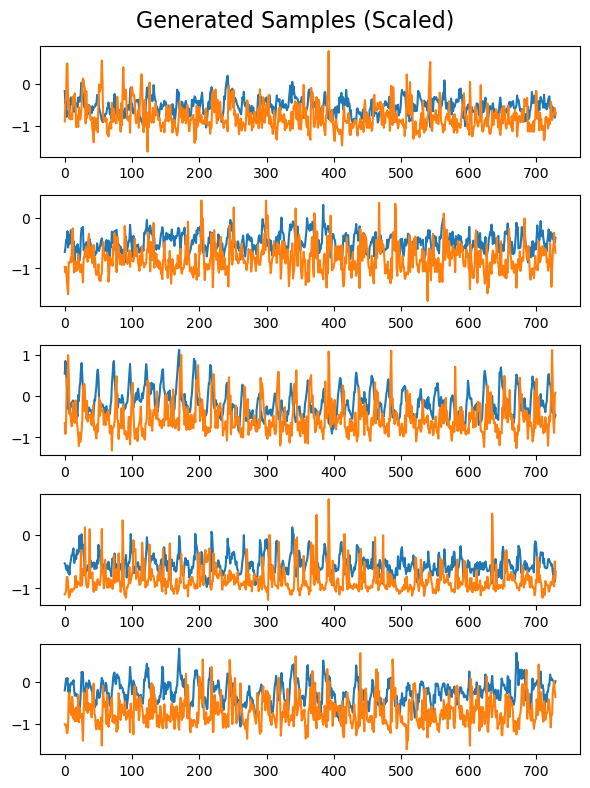

In [30]:
samples = np.load(f'../../data/models/model_data/{model_name}_l3b4_samples.npy')
utils.plot_samples(samples, n=5)

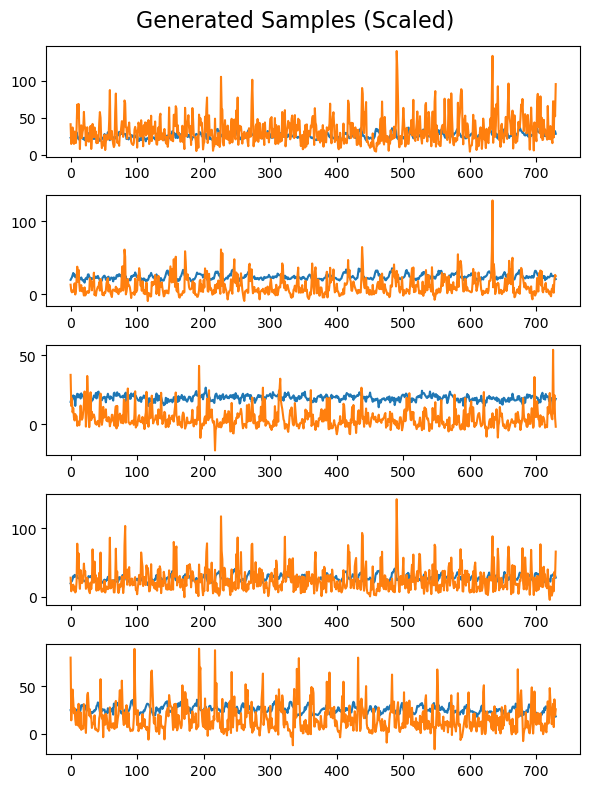

In [28]:
samples = np.load(f'../../data/models/model_data/{model_name}_l3b4_scaled_samples.npy')
utils.plot_samples(samples, n=5)

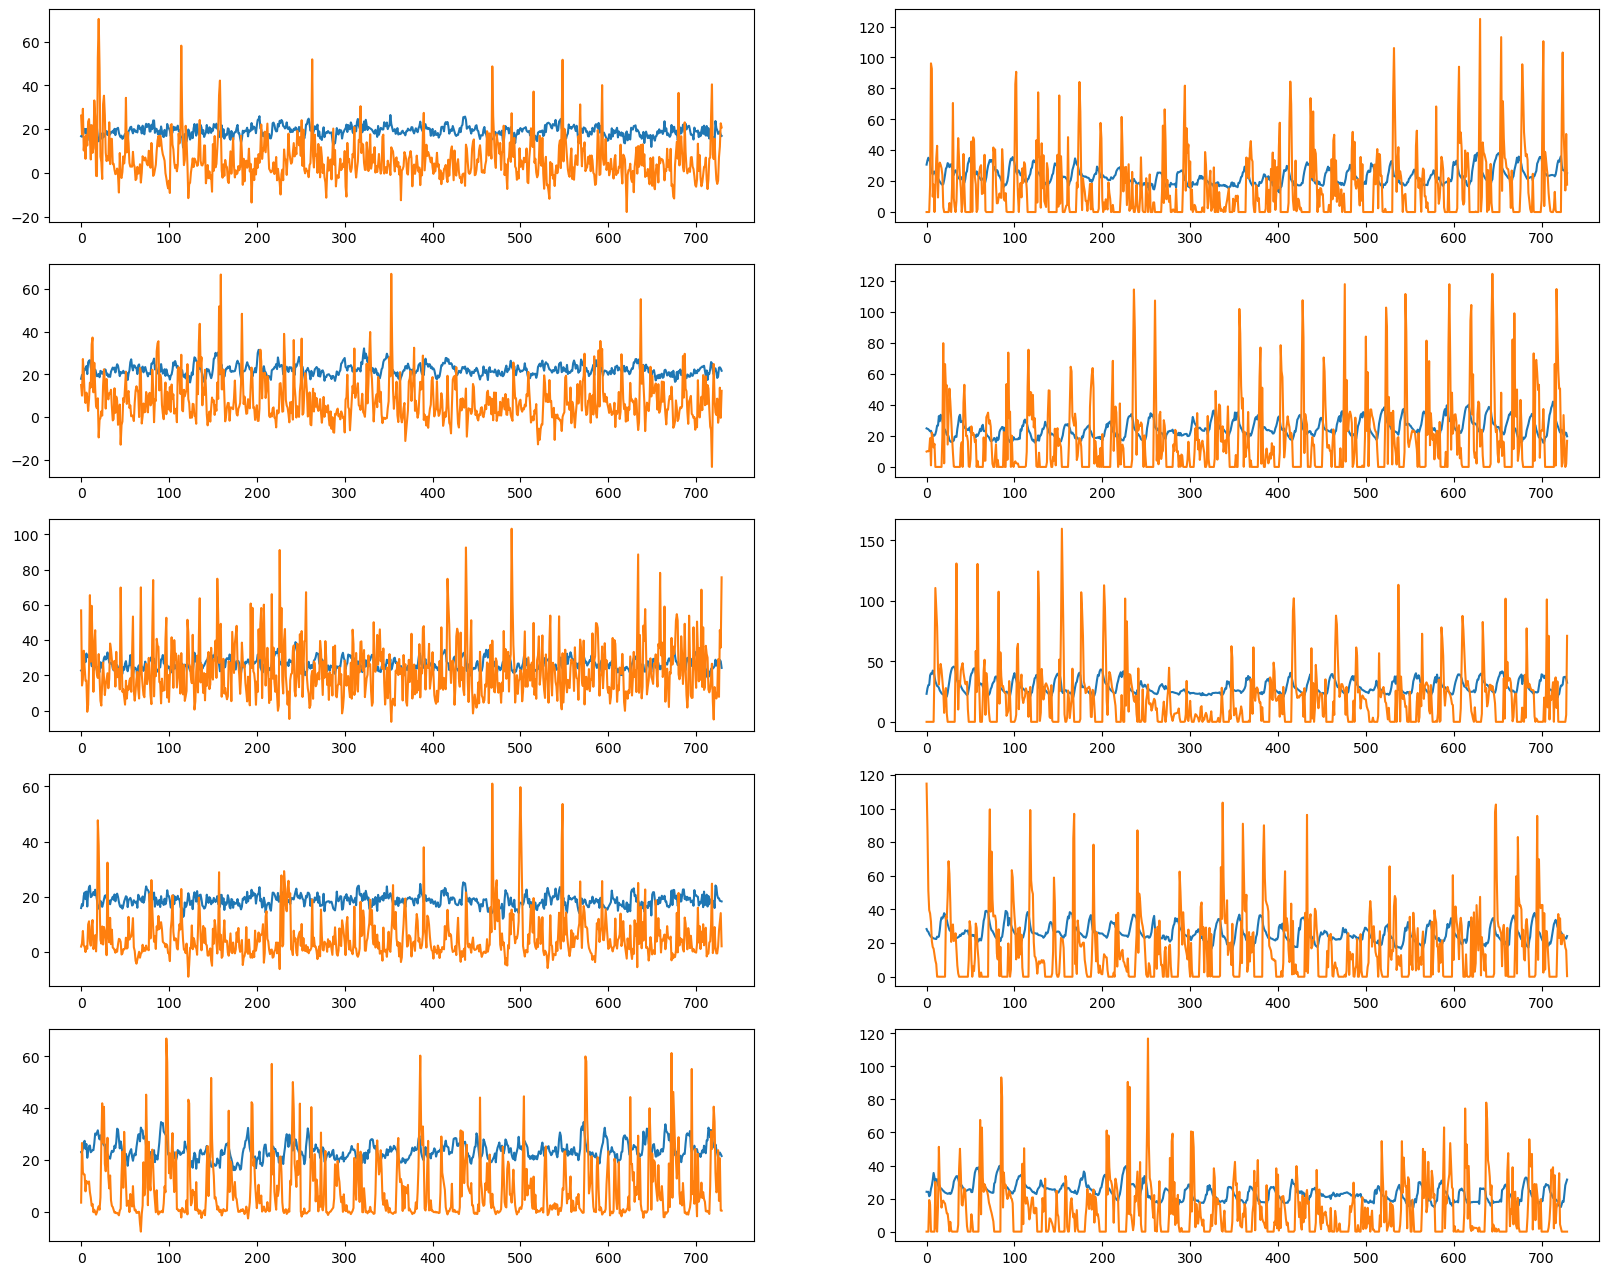

In [26]:
offset = 100
fig, ax = plt.subplots(5, 2, figsize=(20,16))
for i in range(5):
    ax[i,0].plot(samples[i+offset,:])
    ax[i,1].plot(base_data_train[i+offset,:])

Synthetic samples are starting to look a lot better. However negative energy values are impossible. To solve this we can simply truncate all values below 0, or we can shift the values up to be above 0. We can even combine the two approaches as below. (or we can ignore it and hope it doesn't affect evaluation)

In [114]:
scaled_sample = scaled_sample_list[0].copy()

sub_zero_vals = scaled_sample[:,:,1][scaled_sample[:,:,1] < 0]
sub_zero99 = np.percentile(sub_zero_vals, 20)

print(sub_zero99)
scaled_sample[:,:,1] += abs(sub_zero99)

-3.0234012603759766


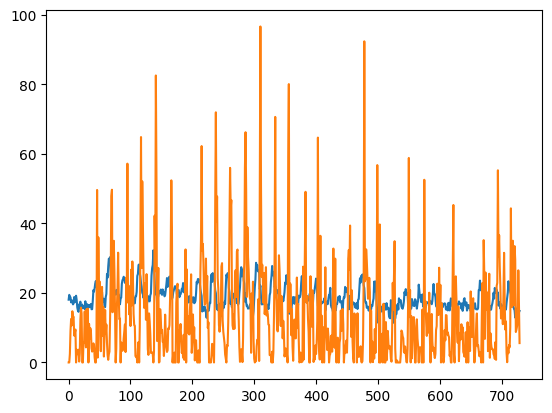

In [116]:
scaled_sample = np.where(scaled_sample < 0, 0, scaled_sample)
plt.plot(scaled_sample[0])

In [122]:
np.save('../data/th_v_air_sample.npy',scaled_sample)#_list[0])

<h3> Selecting the best model </h3>

3, 16:	1206.52490234375, 147.5886993408203
	1206.52490234375, 142.17529296875



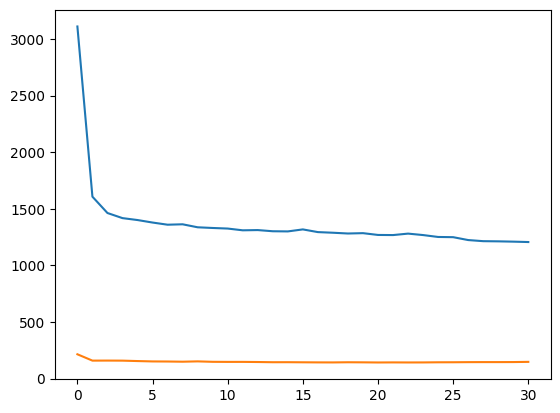

5, 16:	1082.133056640625, 214.4638519287109
	1082.133056640625, 197.25733947753903



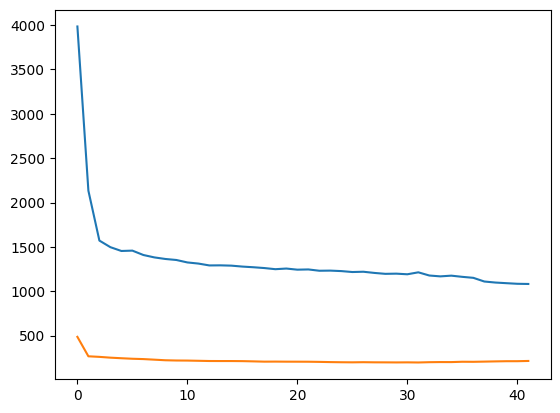

In [208]:
latent_dims = [3,5]
batch_sizes = [16]#,24,32]
min_loss = 1000

for l_dim in latent_dims:
    for b_size in batch_sizes:
        loss = pd.read_csv(f'../data/tuning/junkrun1/lr0.001l{l_dim}b{b_size}_hist.csv')
        print(f'{l_dim}, {b_size}:\t{loss["reconstruction_loss"].iloc[-1]}, {loss["kl_loss"].iloc[-1]}')
        
        print(f'\t{loss["reconstruction_loss"].min()}, {loss["kl_loss"].min()}\n')
        plt.plot(loss[["reconstruction_loss", "kl_loss"]])
        plt.show()

(1000, 730, 3) (1000, 730, 3)


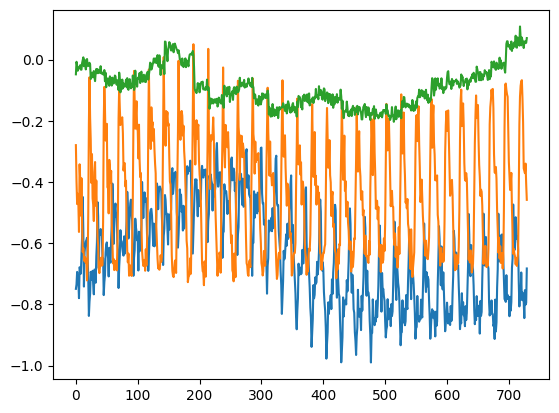

In [205]:
samples = np.load('../data/tuning/junkrun1/lr0.001l3b16_samples.npy')
scaled_samples = np.load('../data/tuning/junkrun1/lr0.001l3b16_scaled_samples.npy')
print(samples.shape, scaled_samples.shape)
plt.plot(samples[2,:])

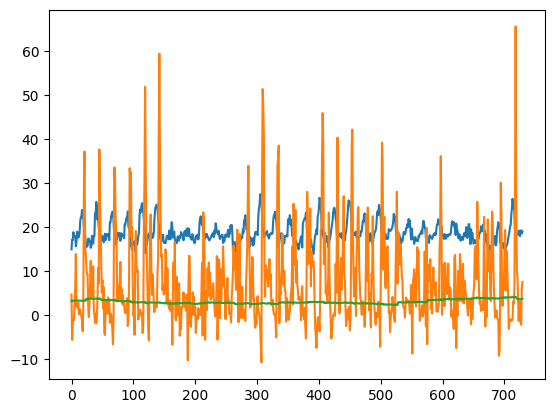

In [418]:
plt.plot(rescaled_samples[2,:])

In [378]:
reshaped_sample = scaled_samples.reshape(-1, 3)
print(pd.DataFrame(reshaped_sample, columns=['G.air.T', 'G.E_th_I', 'month']).describe())

             G.air.T       G.E_th_I          month
count  730000.000000  730000.000000  730000.000000
mean       19.788651      10.604332       6.386692
std         4.279791      10.048422       2.895654
min        -3.002542     -42.836674      -2.924322
25%        17.282743       3.230851       4.175731
50%        19.039019       8.354959       6.296662
75%        21.934312      14.714235       8.583144
max        39.231400      80.863464      15.535751


<h3> Create datasets for testing strategies </h3>

Must create:
 - Purely synthetic dataset
 - Synthetic runs into real data
 - Synthetic-Real blended dataset

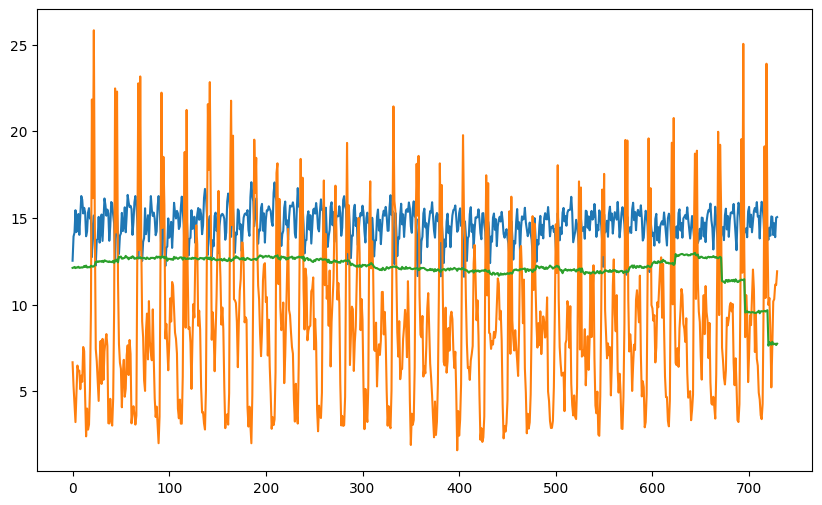

In [217]:
i = 656

plt.figure(figsize=(10,6))
plt.plot(scaled_samples[i,:])
plt.show()

In [285]:
means = np.mean(scaled_samples[:,:,2],axis=1)
sorted_means, sorted_i = np.sort(np.rint(means)), np.argsort(np.rint(means))

for i in range(len(sorted_i)):
    print(f'{sorted_i[i]}: {sorted_means[i]}')

259: -2.0
824: -1.0
272: -0.0
714: 0.0
52: -0.0
956: 0.0
276: 1.0
605: 1.0
600: 1.0
645: 1.0
23: 1.0
926: 1.0
34: 1.0
554: 1.0
221: 1.0
523: 1.0
584: 1.0
654: 1.0
237: 1.0
415: 1.0
16: 1.0
282: 1.0
777: 2.0
539: 2.0
94: 2.0
766: 2.0
763: 2.0
818: 2.0
129: 2.0
558: 2.0
569: 2.0
826: 2.0
734: 2.0
683: 2.0
681: 2.0
163: 2.0
187: 2.0
869: 2.0
536: 2.0
762: 2.0
499: 2.0
545: 2.0
477: 2.0
463: 2.0
262: 2.0
985: 2.0
296: 2.0
954: 2.0
521: 2.0
448: 2.0
37: 2.0
935: 2.0
712: 3.0
705: 3.0
691: 3.0
717: 3.0
401: 3.0
719: 3.0
398: 3.0
737: 3.0
235: 3.0
385: 3.0
393: 3.0
404: 3.0
351: 3.0
347: 3.0
342: 3.0
340: 3.0
124: 3.0
123: 3.0
338: 3.0
788: 3.0
753: 3.0
334: 3.0
281: 3.0
168: 3.0
527: 3.0
232: 3.0
230: 3.0
524: 3.0
222: 3.0
111: 3.0
470: 3.0
561: 3.0
573: 3.0
579: 3.0
200: 3.0
454: 3.0
194: 3.0
603: 3.0
433: 3.0
422: 3.0
610: 3.0
619: 3.0
632: 3.0
173: 3.0
420: 3.0
238: 3.0
661: 3.0
414: 3.0
800: 3.0
161: 3.0
54: 3.0
942: 3.0
76: 3.0
90: 3.0
89: 3.0
974: 3.0
983: 3.0
42: 3.0
885: 3.0
886: 3.0

In [304]:
year_samples = []

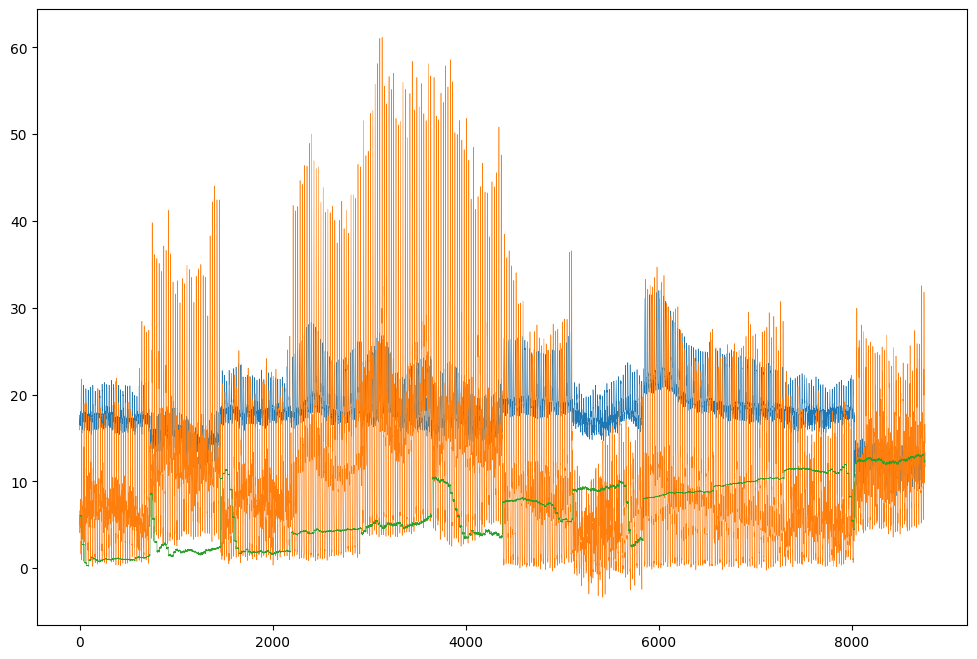

In [350]:
import random

sorted_means = {}
for i, mean in enumerate(np.rint(means)):
    if mean not in sorted_means:
        sorted_means[mean] = []
    sorted_means[mean].append(i)

target_means = np.arange(1,13)

selected_samples = []
for target in target_means:
    #samples_in_month = sorted_means[target]
    #print(target, len(samples_in_month))

    selected_sample = random.choice(sorted_means[target])
    selected_samples.append(scaled_samples[selected_sample])

plt.figure(figsize=(12,8))
plt.plot(np.concatenate(selected_samples, axis=0), linewidth=0.4)

In [351]:
year_samples.append(np.concatenate(selected_samples, axis=0))
print(len(year_samples))

10


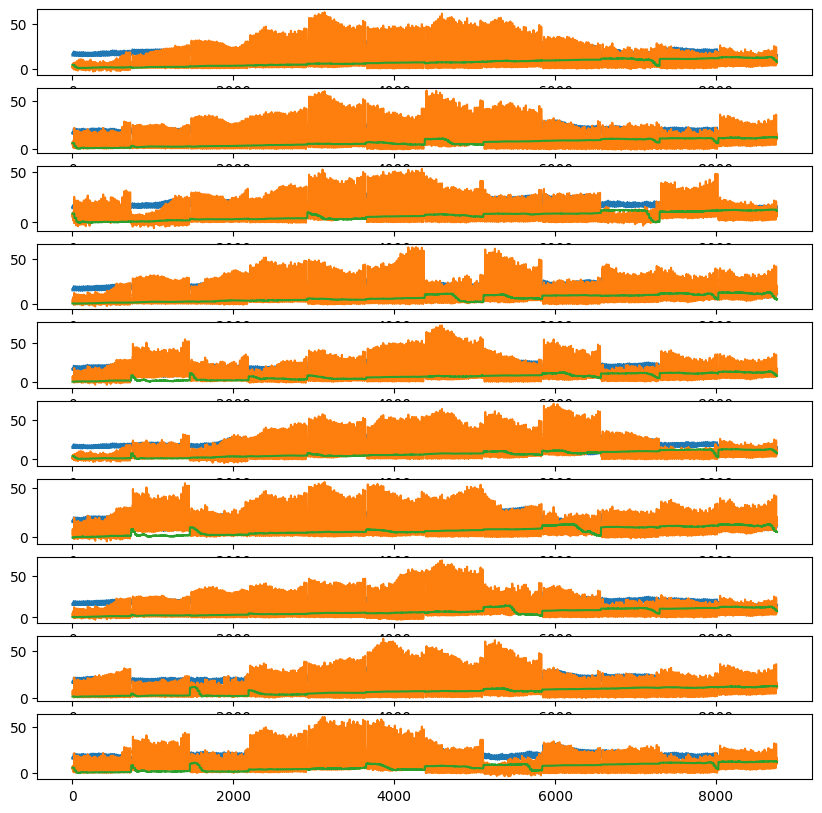

In [354]:
fig, ax = plt.subplots(10,1,figsize=(10,10))
for i in range(10):
    ax[i].plot(year_samples[i])

plt.show()